# Реализация свёрточной нейронной сети для сегментации

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

### 1) Входные данные

In [ ]:
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

def mask_transform(mask):
    mask = F.resize(mask, (128, 128), interpolation=F.InterpolationMode.NEAREST)
    mask = F.pil_to_tensor(mask).squeeze(0).long()
    return mask

train_data = VOCSegmentation(root='./data', year='2012', image_set='train', download=True,
                             transform=image_transform, target_transform=mask_transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

val_data = VOCSegmentation(root='./data', year='2012', image_set='val', download=True,
                           transform=image_transform, target_transform=mask_transform)

val_loader = DataLoader(val_data, batch_size=128, shuffle=False)


### 2) Модель нейронной сети

In [ ]:
class SimpleSegNet(nn.Module):
  def __init__(self, num_classes):
    super(SimpleSegNet, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
    )

    self.bottleneck = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
    )

  def forward(self, x):

    x = self.encoder(x)

    x = self.bottleneck(x)

    x = self.decoder(x)

    return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSegNet(21).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3) Тестирование модели

In [ ]:
def evaluate(model, loader, device):
  model.eval()
  total_iou = 0
  total_accuracy = 0
  total_samples = 0

  with torch.no_grad():
    for images, masks in loader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)

      for pred, mask in zip(predictions, masks):
        intersection = torch.logical_and(pred == mask, mask > 0).sum().item()
        union = torch.logical_or(pred > 0, mask > 0).sum().item()
        iou = intersection / union if union > 0 else 0
        total_iou += iou

      correct_pixels = (predictions == mask).sum().item()
      total_pixels = mask.numel()
      total_accuracy += correct_pixels / total_pixels
      total_samples += 1

  avg_iou = total_iou / total_samples
  avg_accuracy = total_accuracy / total_samples
  return avg_iou, avg_accuracy

### 4) Ранняя остановка

In [ ]:
class EarlyStopping:
  def __init__(self, patience=5):
    self.patience = patience
    self.best_loss = None
    self.counter = 0

  def should_stop(self, val_loss):
    if self.best_loss is None or val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

### 5) ModelCheckpoint

In [ ]:
class ModelCheckpoint:
  def __init__(self, filepath, monitor="val_loss", mode="min", verbose=True):
    self.filepath = filepath
    self.monitor = monitor
    self.mode = mode
    self.best_score = None
    self.verbose = verbose

  def save_checkpoint(self, model, epoch, val_score):
        if self.best_score is None or (
            self.mode == 'min' and val_score < self.best_score or
            self.mode == 'max' and val_score > self.best_score
        ):
            self.best_score = val_score
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"✅ Модель сохранена на эпохе {epoch+1} с {self.monitor}: {val_score:.4f}")


### 6) Тренировка и тестирование модели

In [19]:
early_stopping = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min', verbose=True)

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    val_iou, val_accuracy = evaluate(model, val_loader, device)

    print(f"Эпоха [{epoch+1}/{20}], Потери: {avg_train_loss:.4f}, Точность на валидации: {val_accuracy:.4f}, IOU на валидации: {val_iou:.4f}")

    checkpoint.save_checkpoint(model, epoch, avg_train_loss)

    if early_stopping.should_stop(avg_train_loss):
        print("Ранняя остановка сработала.")
        break

model.load_state_dict(torch.load('best_model.pth'))

test_iou, test_accuracy = evaluate(model, val_loader, device)
print(f"Точность на тесте: {test_accuracy:.4f}")
print(f"IOU на тесте: {test_iou:.4f}")


100%|██████████| 12/12 [05:00<00:00, 25.06s/it]


Эпоха [1/20], Потери: 2.2713, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 1 с val_loss: 2.2713


100%|██████████| 12/12 [04:40<00:00, 23.38s/it]


Эпоха [2/20], Потери: 1.5733, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 2 с val_loss: 1.5733


100%|██████████| 12/12 [04:36<00:00, 23.07s/it]


Эпоха [3/20], Потери: 1.4642, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 3 с val_loss: 1.4642


100%|██████████| 12/12 [04:47<00:00, 23.99s/it]


Эпоха [4/20], Потери: 1.3857, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 4 с val_loss: 1.3857


100%|██████████| 12/12 [04:39<00:00, 23.26s/it]


Эпоха [5/20], Потери: 1.3176, Точность на валидации: 75.1118, IOU на валидации: 0.0063
✅ Модель сохранена на эпохе 5 с val_loss: 1.3176


100%|██████████| 12/12 [04:41<00:00, 23.45s/it]


Эпоха [6/20], Потери: 1.2853, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 6 с val_loss: 1.2853


100%|██████████| 12/12 [04:47<00:00, 23.94s/it]


Эпоха [7/20], Потери: 1.2654, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 7 с val_loss: 1.2654


100%|██████████| 12/12 [04:39<00:00, 23.33s/it]


Эпоха [8/20], Потери: 1.2486, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 8 с val_loss: 1.2486


100%|██████████| 12/12 [04:40<00:00, 23.41s/it]


Эпоха [9/20], Потери: 1.2645, Точность на валидации: 75.1208, IOU на валидации: 0.0000


100%|██████████| 12/12 [04:42<00:00, 23.54s/it]


Эпоха [10/20], Потери: 1.2362, Точность на валидации: 75.1208, IOU на валидации: 0.0000
✅ Модель сохранена на эпохе 10 с val_loss: 1.2362


100%|██████████| 12/12 [04:38<00:00, 23.20s/it]


Эпоха [11/20], Потери: 1.2366, Точность на валидации: 75.1208, IOU на валидации: 0.0000


100%|██████████| 12/12 [04:41<00:00, 23.45s/it]


Эпоха [12/20], Потери: 1.2370, Точность на валидации: 75.1208, IOU на валидации: 0.0000


100%|██████████| 12/12 [04:41<00:00, 23.45s/it]


Эпоха [13/20], Потери: 1.2406, Точность на валидации: 75.1208, IOU на валидации: 0.0000


100%|██████████| 12/12 [04:38<00:00, 23.21s/it]


Эпоха [14/20], Потери: 1.2474, Точность на валидации: 75.1208, IOU на валидации: 0.0000


100%|██████████| 12/12 [04:43<00:00, 23.64s/it]


Эпоха [15/20], Потери: 1.2467, Точность на валидации: 75.1208, IOU на валидации: 0.0000
Ранняя остановка сработала.
Точность на тесте: 75.1208
IOU на тесте: 0.0000


# 7) Результаты нейронной сети

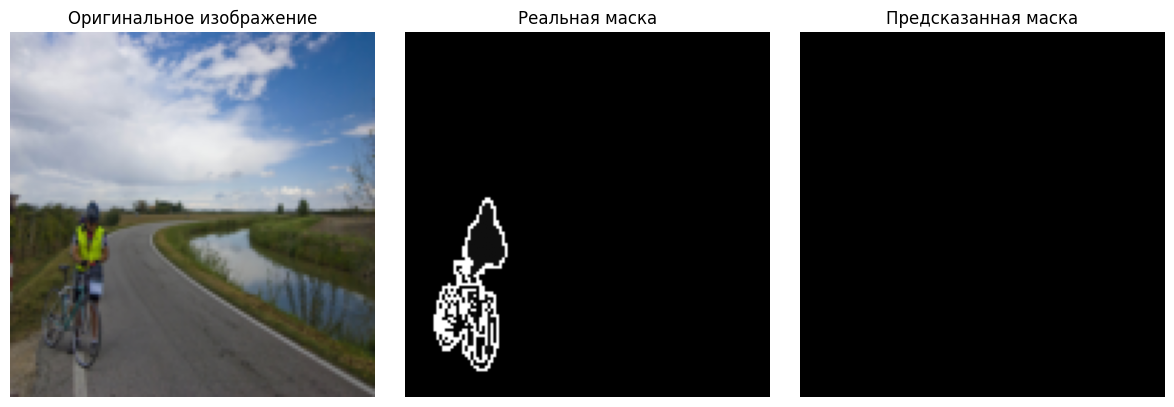

In [20]:
model.eval()
random_index = random.randint(0, len(val_loader.dataset) - 1)

image, mask = val_loader.dataset[random_index]
image_tensor = image.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

image_np = np.transpose(image.numpy(), (1, 2, 0))
mask_np = mask.numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_np)
plt.title("Оригинальное изображение")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Реальная маска")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap="gray")
plt.title("Предсказанная маска")
plt.axis("off")

plt.tight_layout()
plt.show()